# Analysis of Strava activities - Performances changing over time

In this notebook there is a small analysis of  difference of performances over time in terms of pace, length and VO2Max.

In [1]:
# to avoid geopandas warnings, don't run if you don't mind warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
import pandas as pd
import gpxpy
import os
from tqdm import tqdm
import utils
import json

### Data loading

This part is common for all notebooks, for simplicity. It takes all the Strava activities collected and stores them in lists, dataframes, geodataframes and trajectories for every type of activity (runs, hikes, rides and all).

In [3]:
activities = []
runs = []
hikes = []
rides = []

In [4]:
for file in tqdm(os.listdir("data/strava_activities/")):
    gpx_file = open("data/strava_activities/{}".format(file), 'r')
    gpx = gpxpy.parse(gpx_file)
    if((gpx.tracks[0].type == 'Run') | (gpx.tracks[0].type == 'running') ):
        runs.append(gpx)
        activities.append(gpx)
    elif(gpx.tracks[0].type == 'Hike'):
        hikes.append(gpx)
        activities.append(gpx)
    elif(gpx.tracks[0].type == 'Ride'):
        rides.append(gpx)
        activities.append(gpx)

100%|██████████| 159/159 [00:13<00:00, 12.09it/s]


In [5]:
# list of dataframes of all the activities
activities_dfList = utils.toList(activities)
runs_dfList = utils.toList(runs)
rides_dfList = utils.toList(rides)
hikes_dfList = utils.toList(hikes)

100%|██████████| 14/14 [00:00<00:00, 21.41it/s]


In [6]:
# Set time as index for movingpandas
for i in range(len(activities_dfList)):
    activities_dfList[i].set_index('time', drop=True, inplace=True)
for i in range(len(runs_dfList)):
    runs_dfList[i].set_index('time', drop=True, inplace=True)
for i in range(len(rides_dfList)):
    rides_dfList[i].set_index('time', drop=True, inplace=True)
for i in range(len(hikes_dfList)):
    hikes_dfList[i].set_index('time', drop=True, inplace=True)

In [7]:
# List of geodataframes of activities
geo_dfList = utils.toGdfList(activities_dfList)
runs_geo_dfList = utils.toGdfList(runs_dfList)
rides_geo_dfList = utils.toGdfList(rides_dfList)
hikes_geo_dfList = utils.toGdfList(hikes_dfList)

100%|██████████| 14/14 [00:00<00:00, 40.64it/s]


In [8]:
# List of all trajectories of the dataset
trajectories = utils.getTrajList(geo_dfList)
runsTrajectories = utils.getTrajList(runs_geo_dfList)
ridesTrajectories = utils.getTrajList(rides_geo_dfList)
hikesTrajectories = utils.getTrajList(hikes_geo_dfList)

In [9]:
for i in tqdm(range(len(runsTrajectories))):
    runsTrajectories[i].add_speed(overwrite=True)
for i in tqdm(range(len(runsTrajectories))):
    runsTrajectories[i].df['kmh'] = runsTrajectories[i].df['speed'].apply(utils.ms_to_km)

100%|██████████| 135/135 [00:00<00:00, 585.37it/s]


### Getting average pace and runs' lengths

In [10]:
runAvg = pd.DataFrame(columns={'date', 'avgPace', 'length'})
for i in tqdm(range(len(runsTrajectories))):
    runAvg.at[i, 'date'] = runsTrajectories[i].get_start_time()
    runAvg.at[i, 'avgPace'] = runsTrajectories[i].df.kmh.mean()
    runAvg.at[i, 'length'] = runsTrajectories[i].get_length()/1000

100%|██████████| 135/135 [00:31<00:00,  4.25it/s]


In [11]:
runAvg.sort_values(by='date', inplace=True)
runAvg.reset_index(drop=True, inplace=True)
for i in tqdm(range(len(runAvg))):
    runAvg.date[i] = runAvg.date[i].strftime("%Y-%m-%d")
runAvg

100%|██████████| 135/135 [00:00<00:00, 5499.42it/s]


,length,date,avgPace
0,5.80499,2019-04-09,10.9627
1,3.00899,2019-04-11,12.725
2,3.9967,2019-04-16,12.8169
3,3.94465,2019-04-17,11.2084
4,3.01506,2019-05-01,12.7177
...,...,...,...
130,6.45656,2021-08-30,10.4523
131,8.03258,2021-09-23,12.7818
132,10.0129,2021-09-27,12.1618
133,6.60791,2021-09-29,11.4554


### Exploiting VO2Max data

VO2Max is a measure of maximum oxygen consumption per minute for any muscle contraction. This is a biological parameter which can be partially improved by trainings. Was I able to modify it through my activities? When did it decrease?

In [14]:
data = []
vo2 = pd.DataFrame()
for file in tqdm(os.listdir("data/vo2/")):
    with open("data/vo2/{}".format(file), 'r') as f:
        data = json.loads([line.strip() for line in f][0])
        vo2 = vo2.append(data)
vo2.reset_index(drop=True, inplace=True)
vo2.drop(columns={'userProfilePK', 'deviceId','subSport', 'activityUuid'}, inplace=True)
vo2

100%|██████████| 10/10 [00:00<00:00, 90.61it/s]


,calendarDate,timestampGmt,sport,activityId,vo2MaxValue
0,2019-03-20,2019-03-20T18:53:32.0,RUNNING,3479925555,53.0
1,2019-03-26,2019-03-26T18:39:07.0,RUNNING,3498156058,53.0
2,2019-04-02,2019-04-02T17:44:54.0,RUNNING,3519671950,53.0
3,2019-04-09,2019-04-09T18:14:30.0,RUNNING,3541479161,54.0
4,2019-04-11,2019-04-11T06:43:22.0,RUNNING,3545420258,56.0
...,...,...,...,...,...
133,2021-05-14,2021-05-14T11:57:57.0,RUNNING,6777359705,52.0
134,2021-05-15,2021-05-15T09:54:00.0,RUNNING,6782369267,51.0
135,2021-05-18,2021-05-18T17:57:59.0,RUNNING,6802088682,51.0
136,2021-05-23,2021-05-23T18:53:58.0,RUNNING,6830626048,51.0


## Efforts comparison

In [15]:
complete = pd.merge(runAvg, vo2, left_on='date', right_on='calendarDate', how="inner")
complete.drop(columns={'calendarDate'}, inplace=True)
complete

,length,date,avgPace,timestampGmt,sport,activityId,vo2MaxValue
0,5.80499,2019-04-09,10.9627,2019-04-09T18:14:30.0,RUNNING,3541479161,54.0
1,3.00899,2019-04-11,12.725,2019-04-11T06:43:22.0,RUNNING,3545420258,56.0
2,3.9967,2019-04-16,12.8169,2019-04-16T17:51:35.0,RUNNING,3561796047,56.0
3,3.94465,2019-04-17,11.2084,2019-04-17T17:34:43.0,RUNNING,3564901233,56.0
4,3.01506,2019-05-01,12.7177,2019-05-01T18:48:20.0,RUNNING,3609227182,56.0
...,...,...,...,...,...,...,...
118,5.01024,2021-08-14,13.2755,2021-08-14T18:45:04.0,RUNNING,7304989718,52.0
119,8.03258,2021-09-23,12.7818,2021-09-23T18:48:04.0,RUNNING,7541750132,53.0
120,10.0129,2021-09-27,12.1618,2021-09-27T18:26:23.0,RUNNING,7564463452,51.0
121,6.60791,2021-09-29,11.4554,2021-09-29T17:38:44.0,RUNNING,7575641530,52.0


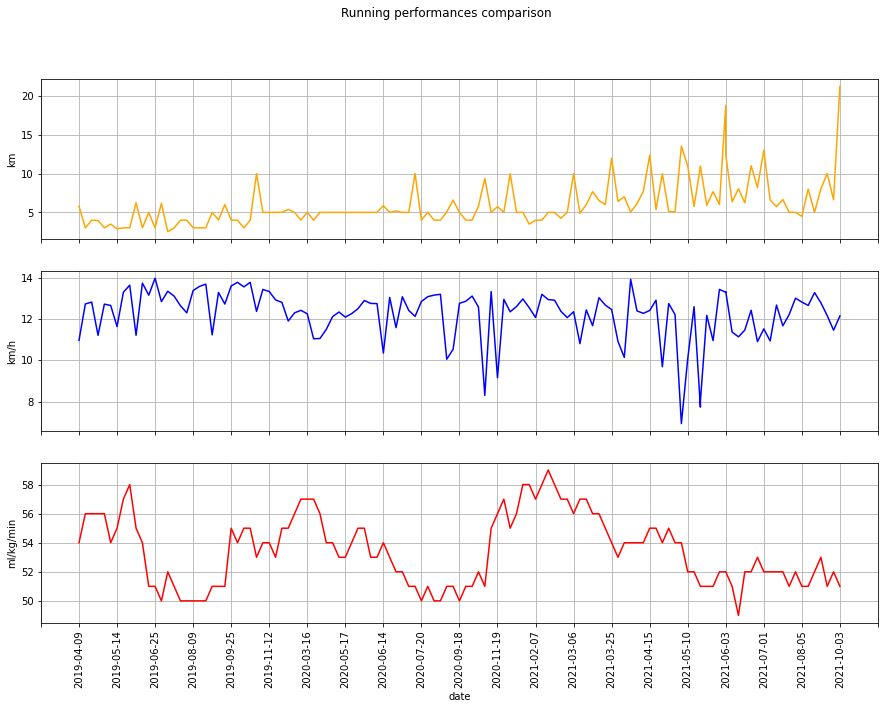

In [16]:
utils.plotRunComparison(complete)

There are some patterns that could be noticed:
* activities' length increased over time, but the average pace didn't change too much (except for some isolated activities)
* VO2Max had a low point after the 2020 spring lockdown, as predictable
* interestingly, autumn 2020 and winter 2021 were the period in which I was more trained (according to VO2Max); in fact, in that period activities' length started to raise, but the average pace didn't decreased